In [1]:
%env OMP_NUM_THREADS=1
import firedrake as fd
import numpy as np
import matplotlib.pyplot as plt
from scattering import *
from mesh import *

env: OMP_NUM_THREADS=1


In [2]:
c = 340
d = fd.as_vector([1., 0.])
h0 = 0.2

# Sphere

In [3]:
shape = "sphere"
a0 = b0 = 2.0
a1 = b1 = 2.25
R0 = 1.2
R1 = 1.9
if R0 is not None and R1 is not None:
    annular = True
else:
    annular = False

cached_mesh = True
if cached_mesh:
    mesh = fd.Mesh(shape + str(0) + ".msh")
else:
    mesh = generate_mesh(a0, a1, b0, b1, shape, h0, R0=R0, R1=R1)

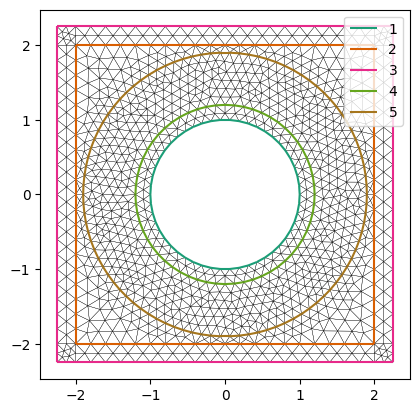

In [4]:
plot_mesh(mesh)

In [5]:
k = 1
omega = k * c
x = fd.SpatialCoordinate(mesh)
kdx = k * fd.dot(d, x)
inc = fd.as_vector((fd.cos(kdx), fd.sin(kdx)))
g = -inc

uh = solve(mesh, k, a0, a1, b0, b1, g, annular=annular)

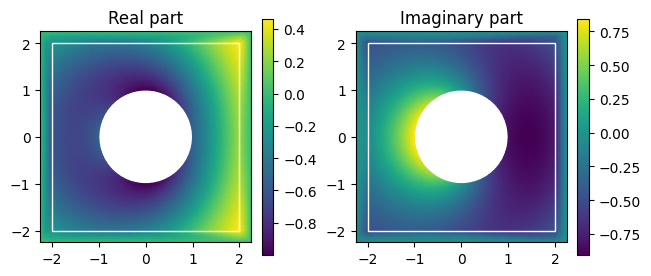

In [6]:
plot_field(uh, a0, a1, b0, b1)

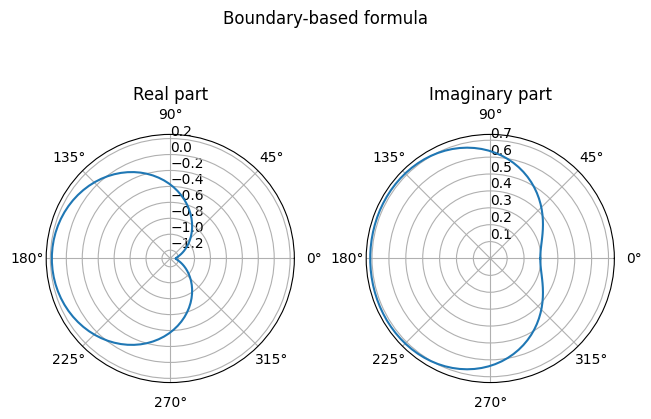

In [7]:
plot_far_field(k, uh, inc)

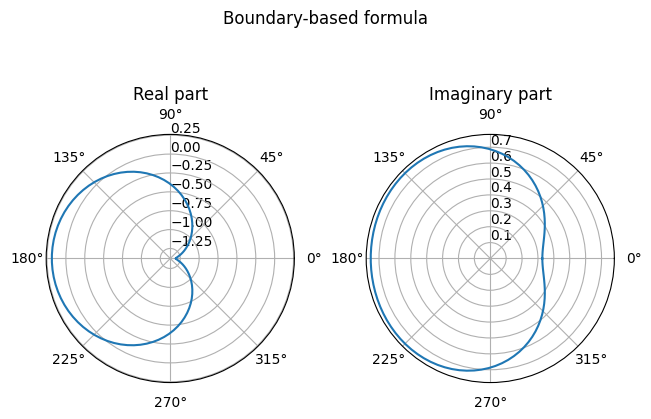

In [8]:
plot_far_field(k, uh, inc, boundary=4)

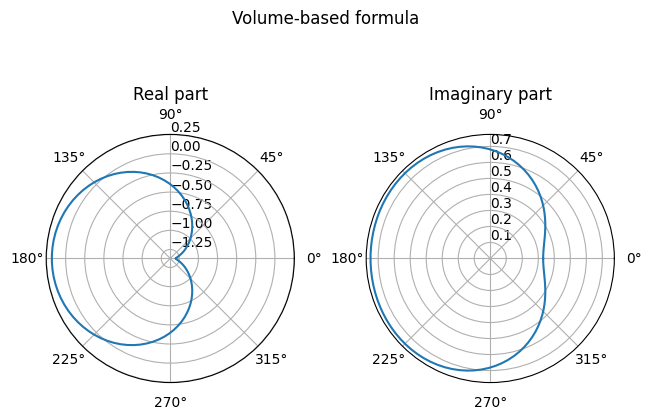

In [9]:
plot_far_field_vol(k, uh, R0, R1, inc)

# Kite

In [10]:
shape = "kite"
a0 = b0 = 2.75
a1 = b1 = 3.0
R0 = 2.3
R1 = 2.7
if R0 is not None and R1 is not None:
    annular = True
else:
    annular = False

cached_mesh = True
if cached_mesh:
    mesh = fd.Mesh(shape + str(0) + ".msh")
else:
    mesh = generate_mesh(a0, a1, b0, b1, shape, h0, R0=R0, R1=R1)

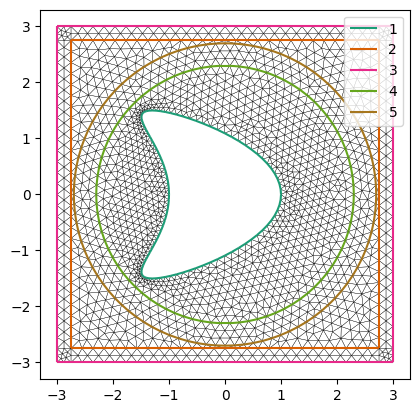

In [11]:
plot_mesh(mesh)

In [12]:
k = 1
omega = k * c
x = fd.SpatialCoordinate(mesh)
kdx = k * fd.dot(d, x)
inc = fd.as_vector((fd.cos(kdx), fd.sin(kdx)))
g = -inc

uh = solve(mesh, k, a0, a1, b0, b1, g, annular=annular)

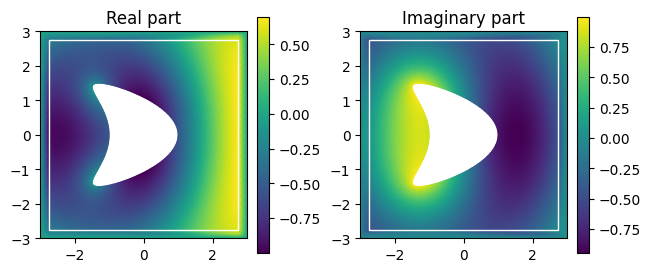

In [13]:
plot_field(uh, a0, a1, b0, b1)

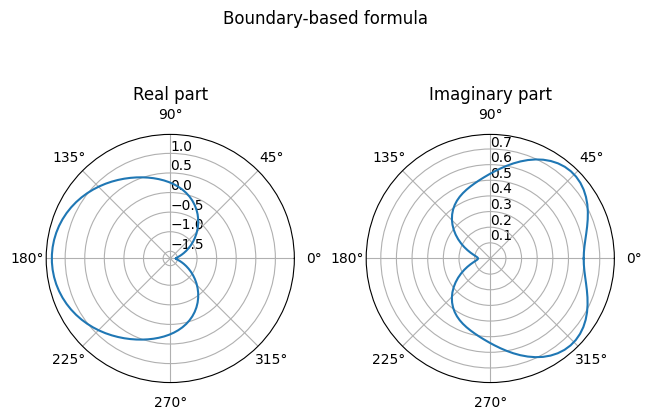

In [14]:
plot_far_field(k, uh, inc)

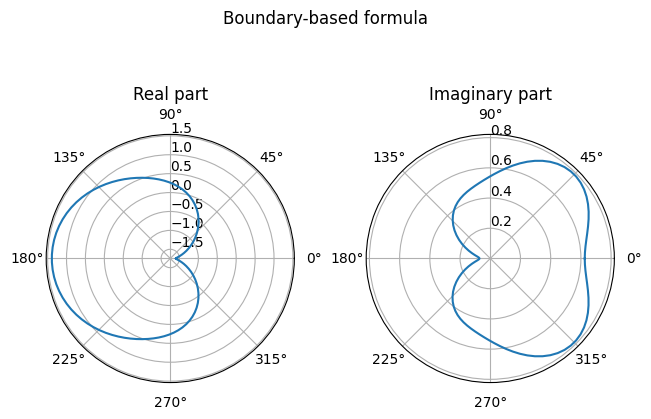

In [15]:
plot_far_field(k, uh, inc, boundary=4)

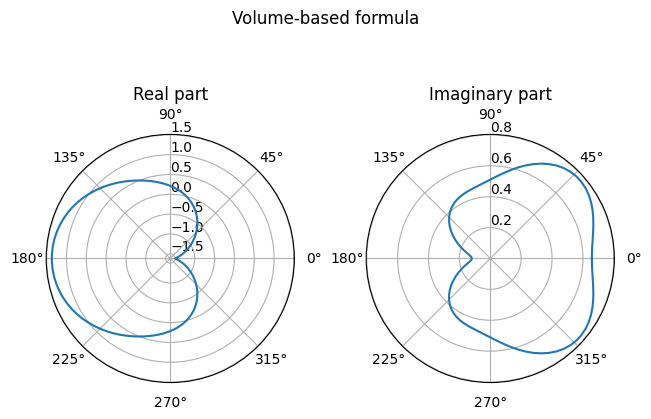

In [16]:
plot_far_field_vol(k, uh, R0, R1, inc)

In [17]:
u_inf = far_field(k, uh, 0, inc)
print("Mesh-boundary-based:")
print("Re{u_inf(d)} =", u_inf[0])
print("Im{u_inf(d)} =", u_inf[1])

u_inf = far_field(k, uh, 0, inc, boundary=4)
print("Arbitrary-boundary-based:")
print("Re{u_inf(d)} =", u_inf[0])
print("Im{u_inf(d)} =", u_inf[1])

u_inf = far_field_vol(k, uh, 0, R0, R1, inc)
print("Volume-based:")
print("Re{u_inf(d)} =", u_inf[0])
print("Im{u_inf(d)} =", u_inf[1])

Mesh-boundary-based:
Re{u_inf(d)} = -1.5387404168937064
Im{u_inf(d)} = 0.5972027636002839
Arbitrary-boundary-based:
Re{u_inf(d)} = -1.5934114779459623
Im{u_inf(d)} = 0.6254250228794522
Volume-based:
Re{u_inf(d)} = -1.4753091192990064
Im{u_inf(d)} = 0.6576794892152008


In [18]:
u_inf = far_field(k, uh, np.pi, inc)
print("Mesh-boundary-based:")
print("Re{u_inf(d)} =", u_inf[0])
print("Im{u_inf(d)} =", u_inf[1])

u_inf = far_field(k, uh, np.pi, inc, boundary=4)
print("Arbitrary-boundary-based:")
print("Re{u_inf(d)} =", u_inf[0])
print("Im{u_inf(d)} =", u_inf[1])

u_inf = far_field_vol(k, uh, np.pi, R0, R1, inc)
print("Volume-based:")
print("Re{u_inf(d)} =", u_inf[0])
print("Im{u_inf(d)} =", u_inf[1])

Mesh-boundary-based:
Re{u_inf(d)} = 1.3409946650034554
Im{u_inf(d)} = 0.07777251528873771
Arbitrary-boundary-based:
Re{u_inf(d)} = 1.3891651664452176
Im{u_inf(d)} = 0.07112724509157381
Volume-based:
Re{u_inf(d)} = 1.3706808841738571
Im{u_inf(d)} = 0.1190358430823807


- $Re\{u_\infty(d)\} = −1.62745750, Im\{u_\infty(d)\} = 0.60222591$  
    $Re\{u_\infty(-d)\} = 1.39694488, Im\{u_\infty(-d)\} = 0.09499635$  
    (Colton and Kress - 2019, Table 3.1)

In [19]:
# Convergence
max_level = 5
levels = np.arange(max_level)
hs = h0 / 2**levels

In [20]:
mesh_hierarchy = []
if cached_mesh:
    for level in levels:
        mesh_hierarchy.append(fd.Mesh(shape + str(level) + ".msh"))
else:
    for level in levels:
        mesh_hierarchy.append(generate_mesh(a0, a1, b0, b1, shape, h0, level, R0=R0, R1=R1))

# mesh_hierarchy = fd.MeshHierarchy(mesh, max_level)

In [21]:
k = 1

if k == 1:
    u_inf_ref = np.array([-1.62745750, 0.60222591, 1.39694488, 0.09499635])
if k == 5:
    u_inf_ref = np.array([-2.47554380, 1.68747937, -0.19945787, 0.06015893])

k = 1
refinement level 0, relative error [0.05451269 0.00834097 0.04005184 0.18131049]
refinement level 1, relative error [0.02119153 0.0025297  0.01785045 0.05808426]
refinement level 2, relative error [0.01061738 0.00146458 0.01266292 0.09389016]
refinement level 3, relative error [0.00503338 0.00121862 0.00164529 0.03222903]
refinement level 4, relative error [0.0026222  0.00113996 0.00121552 0.0188892 ]


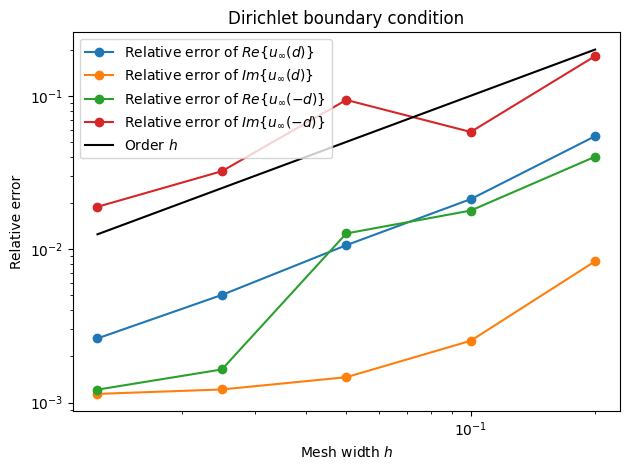

In [22]:
# Dirichlet problem
print(f"k = {k}")
errors = []
for level in levels:
    m = mesh_hierarchy[level]
    x = fd.SpatialCoordinate(m)
    kdx = k * fd.dot(d, x)
    inc = fd.as_vector((fd.cos(kdx), fd.sin(kdx)))
    g = -inc
    
    uh = solve(m, k, a0, a1, b0, b1, g, annular=annular)

    u_inf = np.empty(4)
    u_inf[0], u_inf[1] = far_field(k, uh, 0, inc)
    u_inf[2], u_inf[3] = far_field(k, uh, np.pi, inc)
    rel_err = np.abs((u_inf - u_inf_ref) / u_inf_ref)
    print(f"refinement level {level}, relative error {rel_err}")
    errors.append(rel_err)
errors = np.array(errors)
plt.loglog(hs, errors[:, 0], "-o",
           label=r"Relative error of $Re\{u_\infty(d)\}$")
plt.loglog(hs, errors[:, 1], "-o",
           label=r"Relative error of $Im\{u_\infty(d)\}$")
plt.loglog(hs, errors[:, 2], "-o",
           label=r"Relative error of $Re\{u_\infty(-d)\}$")
plt.loglog(hs, errors[:, 3], "-o",
           label=r"Relative error of $Im\{u_\infty(-d)\}$")

plt.loglog(hs, hs, "k", label=r"Order $h$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Dirichlet boundary condition")
plt.tight_layout()

k = 1
refinement level 0, relative error [0.02091976 0.03852228 0.00556909 0.25126339]
refinement level 1, relative error [0.00409877 0.01243487 0.00053567 0.09181789]
refinement level 2, relative error [0.00195617 0.00580678 0.00397346 0.08021193]
refinement level 3, relative error [0.00052198 0.00246143 0.00289644 0.02565101]
refinement level 4, relative error [0.00042443 0.00066681 0.00100237 0.02228031]


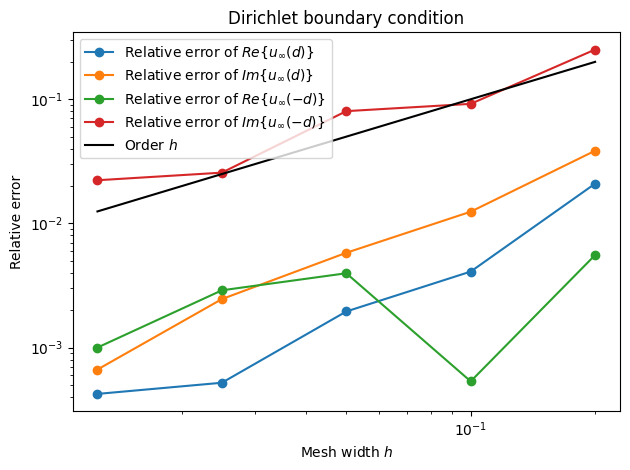

In [23]:
# Dirichlet problem
print(f"k = {k}")
errors = []
for level in levels:
    m = mesh_hierarchy[level]
    x = fd.SpatialCoordinate(m)
    kdx = k * fd.dot(d, x)
    inc = fd.as_vector((fd.cos(kdx), fd.sin(kdx)))
    g = -inc
    
    uh = solve(m, k, a0, a1, b0, b1, g, annular=annular)

    u_inf = np.empty(4)
    u_inf[0], u_inf[1] = far_field(k, uh, 0, inc, boundary=4)
    u_inf[2], u_inf[3] = far_field(k, uh, np.pi, inc, boundary=4)
    rel_err = np.abs((u_inf - u_inf_ref) / u_inf_ref)
    print(f"refinement level {level}, relative error {rel_err}")
    errors.append(rel_err)
errors = np.array(errors)
plt.loglog(hs, errors[:, 0], "-o",
           label=r"Relative error of $Re\{u_\infty(d)\}$")
plt.loglog(hs, errors[:, 1], "-o",
           label=r"Relative error of $Im\{u_\infty(d)\}$")
plt.loglog(hs, errors[:, 2], "-o",
           label=r"Relative error of $Re\{u_\infty(-d)\}$")
plt.loglog(hs, errors[:, 3], "-o",
           label=r"Relative error of $Im\{u_\infty(-d)\}$")

plt.loglog(hs, hs, "k", label=r"Order $h$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Dirichlet boundary condition")
plt.tight_layout()

k = 1
refinement level 0, relative error [0.09348839 0.09208103 0.01880103 0.25305702]
refinement level 1, relative error [0.02262312 0.02916356 0.00372042 0.02897736]
refinement level 2, relative error [0.00649039 0.0098414  0.00467041 0.11053427]
refinement level 3, relative error [0.00178455 0.00341624 0.00262834 0.03332594]
refinement level 4, relative error [0.00073018 0.00088376 0.00094072 0.02058845]


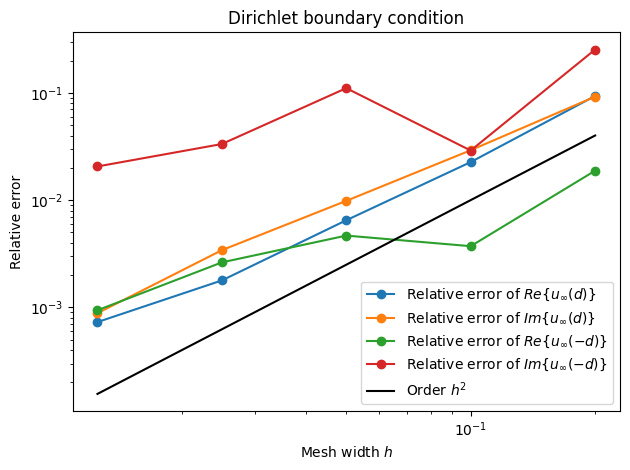

In [24]:
# Dirichlet problem
print(f"k = {k}")
errors = []
for level in levels:
    m = mesh_hierarchy[level]
    x = fd.SpatialCoordinate(m)
    kdx = k * fd.dot(d, x)
    inc = fd.as_vector((fd.cos(kdx), fd.sin(kdx)))
    g = -inc
    
    uh = solve(m, k, a0, a1, b0, b1, g, annular=annular)

    u_inf = np.empty(4)
    u_inf[0], u_inf[1] = far_field_vol(k, uh, 0, R0, R1, inc)
    u_inf[2], u_inf[3] = far_field_vol(k, uh, np.pi, R0, R1, inc)
    rel_err = np.abs((u_inf - u_inf_ref) / u_inf_ref)
    print(f"refinement level {level}, relative error {rel_err}")
    errors.append(rel_err)
errors = np.array(errors)
plt.loglog(hs, errors[:, 0], "-o",
           label=r"Relative error of $Re\{u_\infty(d)\}$")
plt.loglog(hs, errors[:, 1], "-o",
           label=r"Relative error of $Im\{u_\infty(d)\}$")
plt.loglog(hs, errors[:, 2], "-o",
           label=r"Relative error of $Re\{u_\infty(-d)\}$")
plt.loglog(hs, errors[:, 3], "-o",
           label=r"Relative error of $Im\{u_\infty(-d)\}$")

plt.loglog(hs, hs**2, "k", label=r"Order $h^2$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Dirichlet boundary condition")
plt.tight_layout()